In [1]:
%load_ext autoreload
%autoreload 2
from factor_processing_utils import *

In [ ]:
# 研究时间
start_date = "2015-01-01"
end_date = "2025-07-01"

# 基准指数
index_item = "000852.XSHG"
change_days = 20

# 券池
stock_universe = INDEX_FIX(start_date, end_date, index_item)
stock_list = stock_universe.columns.tolist()
date_list = stock_universe.index.tolist()

##### Asness, C. S., Frazzini, A., & Pedersen, L. H. (2019). Quality minus junk. Journal of Finance. 
##### 对 Gordon成长模型的分解定义了质量因子的四个基础组成部分：profitability、growth、payout_ratio, safety
##### 光大证券2018.11.03《以质取胜：EBQC综合质量因子详解》
##### 质量因子：盈利能力、成长能力、营运效率、盈余质量、安全性、公司治理

In [ ]:
## 质量因子
## 全部资产现金回收率 = 经营性现金流/总资产
cfoa_mrq = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
    "total_assets_mrq_0"
)
## 营业利润同比增长率 = （当期营业利润 - 去年同期营业利润）/绝对值（去年同期营业利润）
op_q_yoy_mrq = (
    Factor("profit_from_operation_mrq_0") - Factor("profit_from_operation_mrq_4")
) / ABS(Factor("profit_from_operation_mrq_4"))
## 资产周转率变动 = 当期营业收入/当期总资产 - 去年同期营业收入/去年同期总资产
atdy_mrq = Factor("operating_revenue_mrq_0") / Factor("total_assets_mrq_0") - Factor(
    "operating_revenue_mrq_4"
) / Factor("total_assets_mrq_4")
## 应计利润占比 = 应计利润/营业利润
apr_ttm = (
    Factor("profit_from_operation_ttm_0")
    - Factor("cash_flow_from_operating_activities_ttm_0")
) / Factor("profit_from_operation_ttm_0")
## 现金流动负债率比 = 经营性现金流/流动负债
ccr_mrq = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
    "current_liabilities_mrq_0"
)

# 量价因子
# 估值因子
bp_lyr = Factor("equity_parent_company_lyr_0") / Factor("market_cap_3")

factor_dict = {
    "cfoa_mrq": cfoa_mrq,
    "op_q_yoy_mrq": op_q_yoy_mrq,
    "atdy_mrq": atdy_mrq,
    "apr_ttm": apr_ttm,
    "ccr_mrq": ccr_mrq,
    "liq_zamount": 0,
    "corr_price_turn": 0,
    "vol_high_low_std": 0,
    "mmt_normal_M": 0,
    "bp_lyr": bp_lyr,
}


In [14]:
# 基本面因子
fund_factors = [
    "cfoa_mrq",  # 经营现金流
    "op_q_yoy_mrq",  # 营业利润同比增长
    "atdy_mrq",  # 总资产周转率
    "ccr_mrq",  # 现金转换周期
    "apr_ttm",  # 应付账款周转率
    # "bp_lyr",  # 账面市值比
]

# 量价因子
tech_factors = [
    "liq_zamount",  # 流动性
    "corr_price_turn",  # 价格换手率相关性
    "vol_high_low_std",  # 波动率
    "mmt_normal_M",  # 动量
]

# 所有因子（基本面 + 量价）
factor_names = fund_factors

In [ ]:
import time

for k, v in tqdm(factor_dict.items()):

    # 获取raw因子值
    df = execute_factor(v, stock_list, start_date, end_date)
    raw_path = f"factor_lib/raw/{k}_{index_item}_{start_date}_{end_date}.pkl"
    df.to_pickle(raw_path)
    
    # 清洗之后存入neu文件夹
    neu_path = f"factor_lib/processed/{k}_{index_item}_{start_date}_{end_date}.pkl"
    df = data_clean(df, stock_universe, index_item)
    df.to_pickle(neu_path)

100%|██████████| 4/4 [03:27<00:00, 51.89s/it]


In [4]:
# 从neu文件夹读取因子值，存入value_dict
value_dict = {}
for k, v in tqdm(factor_dict.items()):
    value_dict[k] = pd.read_pickle(
        f"factor_lib/processed/{k}_{index_item}_{start_date}_{end_date}.pkl"
    )

100%|██████████| 10/10 [00:00<00:00, 51.75it/s]


In [7]:
ic_df = pd.DataFrame(index=date_list)
ic_summary = pd.DataFrame()
for k, v in value_dict.items():
    ic, ic_summary_single = calc_ic(v, change_days, index_item, k)
    ic_df = pd.concat([ic_df, ic.to_frame(k)], axis=1)
    ic_summary = pd.concat([ic_summary, ic_summary_single.set_index("name")], axis=0)

{'name': 'cfoa_mrq', 'change_day': 20, 'IC mean': 0.019, 'IC std': 0.052, 'ICIR': 0.3645, 'IC>0': 0.64, 'ABS_IC>2%': 0.7009, 't_stat': 18.3248}
{'name': 'op_q_yoy_mrq', 'change_day': 20, 'IC mean': 0.0326, 'IC std': 0.0702, 'ICIR': 0.4649, 'IC>0': 0.6891, 'ABS_IC>2%': 0.7963, 't_stat': 23.3751}
{'name': 'atdy_mrq', 'change_day': 20, 'IC mean': 0.021, 'IC std': 0.0505, 'ICIR': 0.4167, 'IC>0': 0.6669, 'ABS_IC>2%': 0.7464, 't_stat': 20.9536}
{'name': 'apr_ttm', 'change_day': 20, 'IC mean': 0.0155, 'IC std': 0.0446, 'ICIR': 0.3481, 'IC>0': 0.6479, 'ABS_IC>2%': 0.6748, 't_stat': 17.5018}
{'name': 'ccr_mrq', 'change_day': 20, 'IC mean': 0.0185, 'IC std': 0.0479, 'ICIR': 0.3862, 'IC>0': 0.6452, 'ABS_IC>2%': 0.6709, 't_stat': 19.4173}
{'name': 'liq_zamount', 'change_day': 20, 'IC mean': 0.0521, 'IC std': 0.058, 'ICIR': 0.8975, 'IC>0': 0.8066, 'ABS_IC>2%': 0.7931, 't_stat': 45.125}
{'name': 'corr_price_turn', 'change_day': 20, 'IC mean': 0.0574, 'IC std': 0.0685, 'ICIR': 0.8385, 'IC>0': 0.7931,

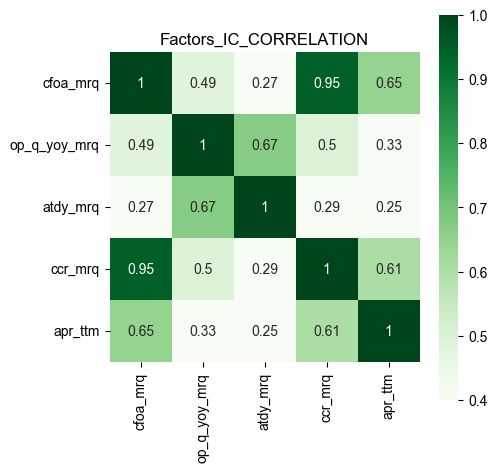

In [16]:
hot_corr(factor_names, ic_df)

In [31]:
ew_combo = pd.DataFrame()
for factor_name in ebqc_factors:
    ew_combo = ew_combo.add(standardize(value_dict[factor_name]), fill_value=0)

In [34]:
# 第一步：合成除bp_lyr外的其他质量因子为ebqc
ebqc_factors = [factor for factor in factor_names if factor != "bp_lyr"]

# 等权合成ebqc
ebqc = pd.DataFrame()
for factor_name in ebqc_factors:
    ebqc = ebqc.add(standardize(value_dict[factor_name]), fill_value=0)

# 标准化ebqc
ebqc = standardize(ebqc)

# 第二步：ebqc与bp_lyr等权合成最终因子
final_combo = pd.DataFrame()
final_combo = final_combo.add(ebqc, fill_value=0)
final_combo = final_combo.add(standardize(value_dict["bp_lyr"]), fill_value=0)

# 最终标准化
ew_combo = standardize(final_combo)

{'name': 'ew_combo', 'change_day': 20, 'IC mean': 0.0487, 'IC std': 0.0943, 'ICIR': 0.5158, 'IC>0': 0.7231, 'ABS_IC>2%': 0.8742, 't_stat': 25.9339}


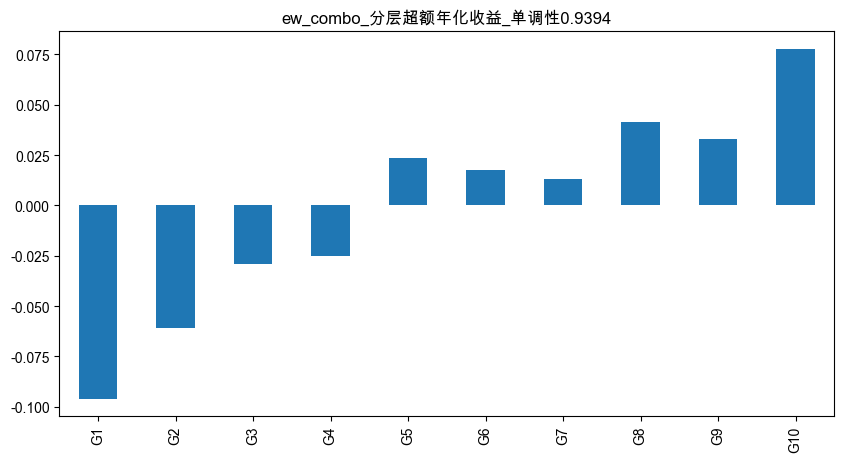

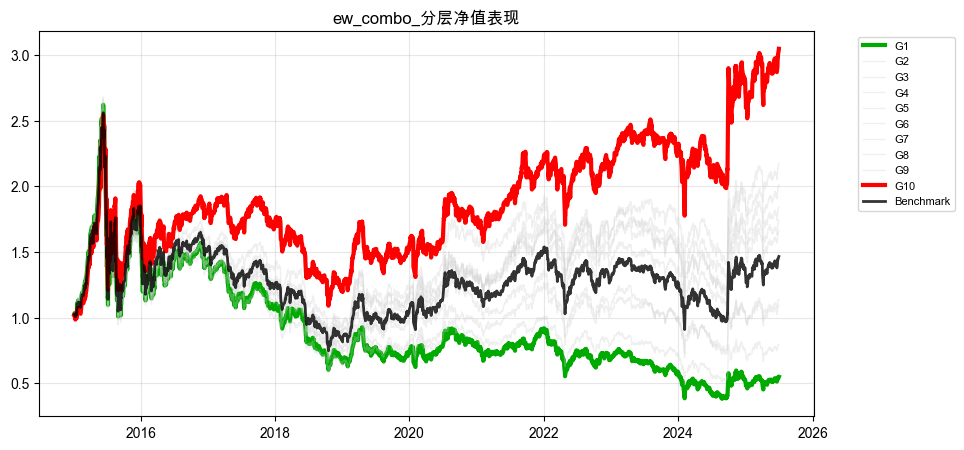

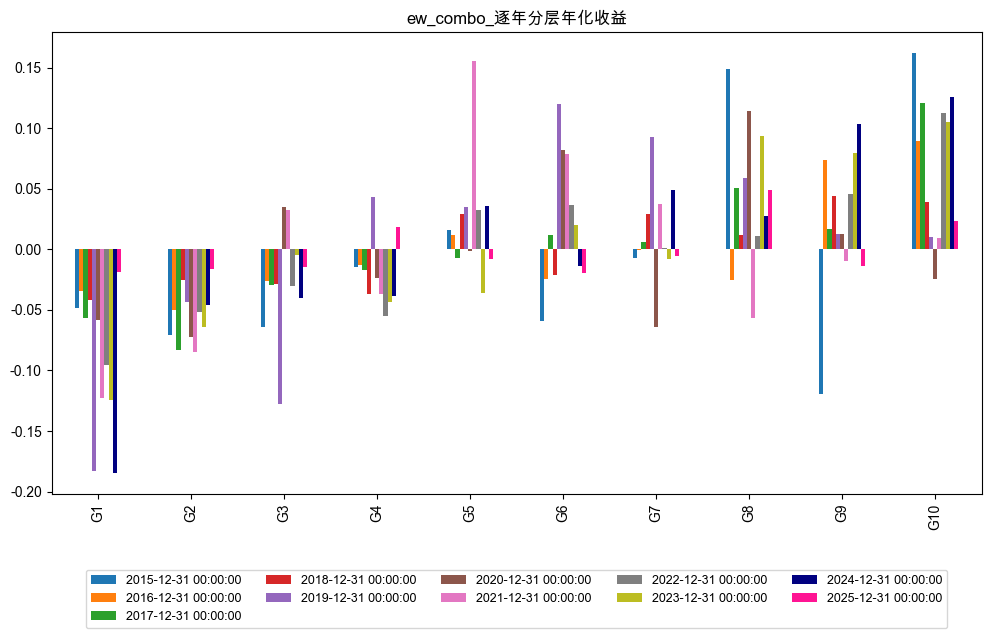

In [35]:
ic, ic_report = calc_ic(ew_combo, 20, index_item, "ew_combo")
return_group, turnover_ratio = factor_layered_backtest(
    ew_combo, change_days, 10, index_item, name="ew_combo"
)

100%|██████████| 128/128 [00:00<00:00, 490.95it/s]


             0
策略累计收益  2.3381
策略年化收益  0.1266
基准累计收益  0.0630
基准年化收益  0.0061
阿尔法     0.1167
贝塔      0.9573
波动率     0.3115
夏普比率    0.3099
下行波动率   0.2705
索提诺比率   0.3569
跟踪误差    0.1053
信息比率    1.1446
最大回撤    0.5377
卡玛比率    0.2354
超额累计收益  2.1402
超额年化收益  0.1198
超额波动率   0.1056
超额夏普    0.8501
超额最大回撤  0.1652
胜率      0.5306
盈亏比     1.0784


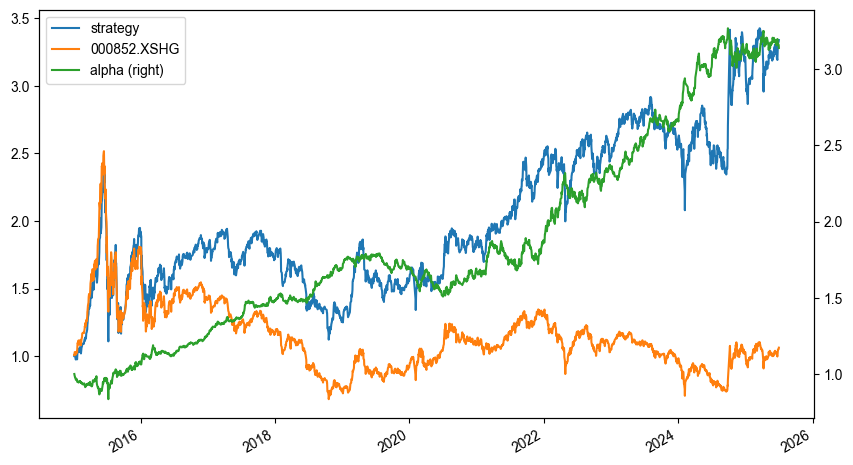

In [36]:
buy_list = get_buy_list(ew_combo, rank_n=50)
df_weight = buy_list.div(buy_list.sum(axis=1), axis=0)
df_weight = df_weight.shift(1).dropna(how="all")
account_result = backtest(df_weight)
performance_cumnet, result = get_performance_analysis(
    account_result, benchmark_index=index_item
)